# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a separate lengthscale for each dimension.

In [62]:
import logging
import numpy as np
from scipy.stats import gamma 

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import GeneralizedLinearModel, StandardLinearModel, Parameter, Positive
from revrand.basis_functions import RandomRBF, OrthogonalRBF
from revrand.likelihoods import Gaussian
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

logging.basicConfig(level=logging.INFO)

### Settings

In [63]:
ALG = 'SLM'

random_state = 100

if ALG == 'GLM':
    lenscale = gamma(2, scale=50)
    regularizer = gamma(2, scale=10)
    var = gamma(2, scale=50)
    nbases = 8192
    nsamples = 10
    batch_size = 10
    maxiter = int(1e6)
    updater = Adam()
elif ALG == 'SLM':
    lenscale = gamma(1, scale=50)
    regularizer = gamma(2, scale=10)
    var = gamma(2, scale=5)
    nbases = 512
    m = 10000
elif ALG == 'GP':
    m = 1024
    n_restarts=1
else:
    raise ValueError("Invalid algorithm")

### Load the data

In [64]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))


Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets and inputs
As per GPML p23

In [65]:
# Targets
ymean = y_train.mean()
y_train -= ymean
y_test -= ymean

# Inputs
Xscaler = StandardScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

### Initialise the algorithms

In [66]:
regularizer_init = Parameter(regularizer, Positive())
lenscale_init = Parameter(lenscale, Positive(), shape=(D,))
base = RandomRBF(nbases=nbases,
                 Xdim=D,
                 lenscale=lenscale_init,
                 random_state=random_state,
                 regularizer=regularizer_init
                )
var_init = Parameter(var, Positive())

if ALG == 'GLM':
    llhood = Gaussian(var=var_init)
    alg = GeneralizedLinearModel(llhood,
                                 base,
                                 updater=updater,
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 nsamples=nsamples,
                                 random_state=random_state
                                )
elif ALG == 'GP':
    kern = 3**2 * RBF(length_scale=np.ones(D), length_scale_bounds=(1e-3, 1e7)) \
        + WhiteKernel(noise_level=1)
    alg = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)
elif ALG == 'SLM':
    alg = StandardLinearModel(
        basis=base,
        var=var_init,
        random_state=random_state
    )
else:
    raise ValueError("Invalid algorithm")
        

### Train the algorithms

In [67]:
rnd = np.random.RandomState(random_state)
if ALG == 'GLM':
    alg.fit(X_train, y_train)
else:
    t_ind = rnd.choice(Ntrain, size=m, replace=False)
    alg.fit(X_train[t_ind], y_train[t_ind])


INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.slm:ELBO = -72302.84401763417, var = 14.464154967282827, reg = 9.565635279198858, hypers = [  46.29238006    5.5548293    24.05876563    1.85789705  110.55117079
  197.95797654    3.09068458  110.61252022   43.00751326   67.83283423
   49.73747613   43.59481938    1.03254508   11.78779884   39.33827622
   73.29181345   14.43047373   16.83631177   95.66080436  184.45696161
  108.07741274].
INFO:revrand.slm:ELBO = -57240.75298080301, var = 18.612476164774026, reg = 2.9819127522585234, hypers = [   9.80567081   13.57037514    2.2949871    35.20347357   23.60047833
   44.92320388   49.70475963    7.69255458  135.78494349  146.29154616
   46.10244614   24.53205872   22.56404034   11.42949761   16.201058
   14.15369407    9.53430219  169.97448376  157.34241188   45.56188653
   65.7081283 ].
INFO:revrand.slm:ELBO = -95131.86137545099, var = 4.681210350736981, reg = 13.474065265834824, hypers = [   4.6309996    37.542546

### Predict and score



SMSE = 0.020127672349979957
MSLL = -1.973052228872672


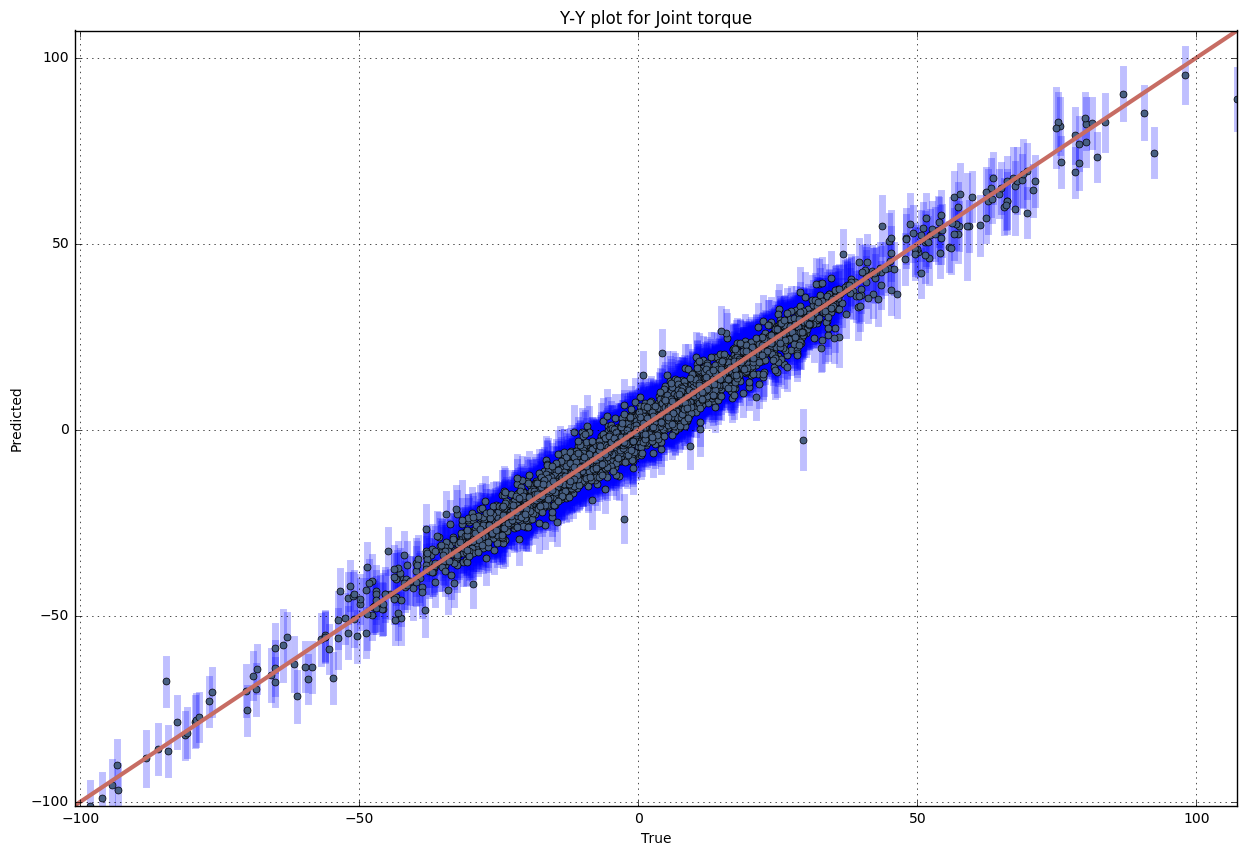

In [68]:
if ALG == 'GLM':
    Ey, Vf = alg.predict_moments(X_test)
    Vy = Vf + alg.like_hypers_
    Sy = np.sqrt(Vy)
elif ALG == 'GP':
    Ey, Sy = alg.predict(X_test, return_std=True)
    Vy = Sy**2
else:
    Ey, Vy = alg.predict_moments(X_test)
    Sy = np.sqrt(Vy)
    
print("SMSE = {}".format(smse(y_test, Ey)))
print("MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

# YY plot
pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")